In [1]:
import os                        # for reading directories
import urllib2                   # for downloading files
import gzip                      # for dealing with gzip files
import re                        # for parsing original files
import pandas as pd              # for csv
import multiprocessing as mp     # for multithread version
import networkx as nx            # for calculating network centralities
import matplotlib.pyplot as plt  # for plots
import collections               # for plotting degree

In [2]:
DATA_DIR = "./data"
IMAGES_DIR = DATA_DIR+"/images"

## Download files

In [3]:
def makedir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    return

def download_file(url, filename):
    f = urllib2.urlopen(url)
    data = f.read()
    with open(filename, "wb") as code:
        code.write(data)
    return

def download_dataset(output_dir=""):
    url = "ftp://ftp.fu-berlin.de/pub/misc/movies/database/temporaryaccess/"
    files = ["movie-links.list.gz", "countries.list.gz", "genres.list.gz"]
    print "Downloading datasets.."
    for fil in files:
        download_file(url+fil, output_dir+"/"+fil)
    print "..done"
    return

def remove_datasets(output_dir=""):
    files = ["movie-links.list.gz", "countries.list.gz", "genres.list.gz"]
    for fil in files:
        os.remove(output_dir+"/"+fil)
    return


In [4]:
makedir(DATA_DIR)
makedir(IMAGES_DIR)

download_dataset(output_dir=DATA_DIR)


..done


# handle data

In [5]:
# get the year of a movie from its title
def get_year_single_movie(title):
    return int(title[-5:-1])

# get dataframe of movie links from gzip file
def get_movie_links(filename):
    regex_movie = re.compile(r'^([^\"][^\(]+ \(\d+\))$')
    regex_links = re.compile(r"\((features|references|follows|spoofs|remake of|spin off from) ([^\"][^\(]+ \(\d+\))\)") #version of??
    result = {"movie": [], "cites": []}
    state = 0 # read movie or reference
    movie = ""
    with gzip.open(filename) as f:
        for line in f:
            if state == 0:  # read movie
                res = re.findall(regex_movie, line)
                if res != []:
                    movie = res[0]
                    state = 1
            elif state == 1: # read reference
                if line == "\n":
                    state = 0
                else:
                    res = re.findall(regex_links, line)
                    if res != []:
                        cites = res[0][1]
                        if(get_year_single_movie(movie) >= get_year_single_movie(cites)):
                            result["movie"] += [movie]
                            result["cites"] += [cites]
    return pd.DataFrame(result, columns = ["movie", "cites"])

# get dataframe of movie countries from gzip file
def get_movie_countries(filename):
    regex_movie_country = re.compile(r'^([^\"][^\(]+ \(\d+\))\t+(.+)$')
    result = {"movie": [], "country": []}
    with gzip.open(filename) as f:
        for line in f:
            res = re.findall(regex_movie_country, line)
            if res != []:
                result["movie"] += [res[0][0]]
                result["country"] += [res[0][1]]
    return pd.DataFrame(result, columns = ["movie", "country"])

# get dataframe of movie genres from gzip file
def get_movie_genres(filename):
    regex_movie_genre = re.compile(r'^([^\"][^\(]+ \(\d+\))\t+(.+)$')
    result = {"movie": [], "genre": []}
    with gzip.open(filename) as f:
        for line in f:
            res = re.findall(regex_movie_genre, line)
            if res != []:
                result["movie"] += [res[0][0]]
                result["genre"] += [res[0][1]]
    return pd.DataFrame(result, columns = ["movie", "genre"]) 

# get dataframe of movie year from movie links csv
def get_movie_year(movie_links_csv):
    movie_year = pd.DataFrame({"movie": list(set(list(movie_links_csv["movie"].unique()) + list(movie_links_csv["cites"].unique())))})
    print len(movie_year)
    movie_year["year"] = movie_year["movie"].apply(lambda x: x[-5:-1])
    return movie_year

def get_grouped(df, y_column, sort_by, ascending):
    return df.groupby(y_column).count().reset_index().sort_values(by = sort_by, ascending = ascending)

#### PLOT STATISTICS

def plot_count_inner(ax, df, x_column, group="id", x_label=None):
    x_label = x_column if x_label == None else x_label
    x_label = "number of "+x_label
    df_local = df.groupby(group).count().reset_index()
    df_local = df_local.groupby(x_column).count().reset_index()
    ax.plot(df_local[x_column], df_local[group], 'o')
    ax.set_yscale('log')
    if max(df_local[x_column]) > 100:
        ax.set_xscale('log')
    ax.set_ylabel("count")
    ax.set_xlabel(x_label)
    return

# plot bar graph
def plot_bars(df, y_column, x_column, x_ticks_step=1, max_value=None):
    if max_value == None:
        plt.bar(range(len(df)), df[x_column])
    else:
        plt.bar(range(len(df)), [(x/float(max_value))*100 for x in df[x_column]])
    plt.xticks(range(0, len(df), x_ticks_step), df[y_column][::x_ticks_step], rotation='vertical')
    #plt.show()
    return

# plot bar grouped
def plot_group_bars(df, y_column, x_column="id", merge_for_labels=None, title="", xlabel="", limit=None, sort_by="id", ascending=False, max_value=None, x_ticks_step=1):
    df_local = get_grouped(df, y_column, sort_by, ascending)
    if limit != None:
        df_local = df_local[:limit]
    if merge_for_labels != None:
        df_local = df_local.merge(merge_for_labels[0], how="left", left_on=y_column, right_on=merge_for_labels[1], suffixes=["","_right"])
        y_column = merge_for_labels[2]
    plot_bars(df_local, y_column, x_column, x_ticks_step=x_ticks_step, max_value=max_value)
    plt.title(title)
    plt.xlabel(xlabel)
    if max_value == None:
        plt.ylabel("count")
    else:
        plt.ylabel("percentage")
    plt.show()
    return

# plot bar grouped
def plot_group_bars_1(df, y_column, x_column="id", title="", xlabel="", xlabel_inner="", limit=None, sort_by="id", ascending=False, max_value=None, x_ticks_step=1, filename=""):
    fig, ax1 = plt.subplots()
    df_local = get_grouped(df, y_column, sort_by, ascending)
    if limit != None:
        df_local = df_local[:limit]
    plot_bars(df_local, y_column, x_column, x_ticks_step=x_ticks_step, max_value=max_value)
    plt.title(title)
    plt.xlabel(xlabel)
    if max_value == None:
        plt.ylabel("count")
    else:
        plt.ylabel("percentage")
    #plot second graph
    left, bottom, width, height = [0.38, 0.45, 0.5, 0.4]
    ax2 = fig.add_axes([left, bottom, width, height])
    plot_count_inner(ax2, df, y_column, group=x_column, x_label=xlabel_inner)
    #save
    if filename != "":
        plt.savefig(filename, bbox_inches='tight', dpi=160)
    plt.show()
    #print df_local
    return

def plot_points_inner(ax, df, y_column, x_column, x_label=None):
    x_label = x_column if x_label == None else x_label
    x_label = "number of "+x_label
    ax.plot(df[y_column], df[x_column], 'o')
    ax.set_yscale('log')
    if max(df[x_column]) > 100:
        ax.set_xscale('log')
    ax.set_ylabel("count")
    ax.set_xlabel(x_label)
    return

def plot_group_bars_2(df, y_column, x_column="id", merge_for_labels=None, title="", xlabel="", xlabel_inner="", limit=None, sort_by="id", ascending=False, max_value=None, y_min=None, x_ticks_step=1, filename=""):
    fig, ax1 = plt.subplots()
    df_local = get_grouped(df, y_column, sort_by, ascending)
    df_local_2 = df_local.groupby(x_column).count().reset_index()
    if limit != None:
        df_local = df_local[:limit]
    if merge_for_labels != None:
        df_local = df_local.merge(merge_for_labels[0], how="left", left_on=y_column, right_on=merge_for_labels[1], suffixes=["","_right"])
        plot_bars(df_local, merge_for_labels[2], x_column, x_ticks_step=x_ticks_step, max_value=max_value)
    else:
        plot_bars(df_local, y_column, x_column, x_ticks_step=x_ticks_step, max_value=max_value)
    plt.title(title)
    plt.xlabel(xlabel)
    if max_value == None:
        plt.ylabel("count")
    else:
        plt.ylabel("percentage")
    if y_min!=None:
        ax1.set_ylim(y_min, ax1.get_ylim()[1])
    #plot second graph
    left, bottom, width, height = [0.38, 0.45, 0.5, 0.4]
    ax2 = fig.add_axes([left, bottom, width, height])
    plot_points_inner(ax2, df_local_2, x_column, y_column, x_label=xlabel_inner)
    #save
    if filename != "":
        plt.savefig(filename, bbox_inches='tight', dpi=160)
    plt.show()
    return

# only for years, plot number of movies by decade
def plot_decades(df_movie_year, filename=""):
    df = df_movie_year[:]
    df.loc[:,"decades"] = (df.loc[:,"year"]//10)*10
    df = get_grouped(df, "decades", "decades", True)
    plot_bars(df, "decades", "id")
    plt.title("Decades")
    plt.xlabel("decades")
    plt.ylabel("count")
    #save
    if filename != "":
        plt.savefig(filename, bbox_inches='tight', dpi=160)
    plt.show()
    return



# given a keyword in a group, returns number of citations in the same group, in other groups and number of movies citing the ones tagged with the keyword
def get_self_citations_single(df, df_links, column, keyword):
    temp = df[df[column] == keyword].merge(df_links)[["cites"]]
    total = len(temp) 
    temp = temp.merge(df, left_on="cites", right_on="id")[[column,"id"]]
    return [len(temp[temp[column] == keyword]), len(temp[temp[column] != keyword]), total]

# apply get_self_citations_single to a set of keywords
def get_self_citations(df, df_links, column, keywords):
    result = {column: [], "self": [], "outer": [], "total": []}
    for keyword in keywords:
        cit = get_self_citations_single(df, df_links, column, keyword)
        result[column] += [keyword]
        result["self"] += [cit[0]]
        result["outer"] += [cit[1]]
        result["total"] += [cit[2]]
    return pd.DataFrame(result, columns = [column, "self", "outer", "total"])

# plot percentage of self-citations in keywords
def plot_self_citations(df, df_links, column, keywords, xlabel="", filename="", limit=20):
    to_plot = get_self_citations(df, df_links, column, keywords)
    to_plot["self"] = to_plot["self"]/to_plot["total"]*100
    to_plot = to_plot.sort_values(by = "self", ascending = False)[:limit]
    to_plot[["self"]].plot.bar(legend=False)
    plt.xticks(range(len(to_plot[column])), to_plot[column], rotation='vertical')
    plt.ylabel("percentage")
    plt.xlabel(xlabel)
    #save
    if filename != "":
        plt.savefig(filename, bbox_inches='tight', dpi=160)
    plt.show()
    return




# save al dataframes and plot statistics
def save_all_dataframes(input_dir="", output_dir="", images_dir=""):
    #read gzip files
    movie_links = get_movie_links(input_dir+"/"+"movie-links.list.gz")
    movie_countries = get_movie_countries(input_dir+"/"+"countries.list.gz")
    movie_genres = get_movie_genres(input_dir+"/"+"genres.list.gz")
    #select only items that intersect all dataframes
    movie_title = movie_links[["cites"]].drop_duplicates()
    movie_title.columns = ["movie"]
    movie_title = movie_title.append(movie_links[["movie"]].drop_duplicates()).drop_duplicates()
    movie_title = movie_title.merge(movie_countries, how="inner")[["movie"]].drop_duplicates()
    movie_title = movie_title.merge(movie_genres, how="inner")[["movie"]].drop_duplicates()
    #create id for each movie
    movie_title = movie_title.sort_values(by = "movie", ascending = True).reset_index()
    movie_title["id"] = movie_title.index
    movie_title.columns = ["index","title", "id"]
    movie_title = movie_title[["id", "title"]]
    #create dataframe for links
    movie_links = movie_links.merge(movie_title, left_on="movie", right_on="title", how="inner")
    movie_links = movie_links.merge(movie_title, left_on="cites", right_on="title", how="inner", suffixes=["_from", "_to"])[["id_from", "id_to"]]
    movie_links.columns = ["id", "cites"]
    #create dataframe for countries
    movie_countries = movie_countries.merge(movie_title, left_on="movie", right_on="title", how="inner")[["id", "country"]]
    #create dataframe for genres
    movie_genres = movie_genres.merge(movie_title, left_on="movie", right_on="title", how="inner")[["id", "genre"]]
    #create dataframe for years
    movie_year = movie_title[:]
    movie_year.loc[:,"year"] = movie_year["title"].apply(lambda x: int(x[-5:-1]))
    movie_year = movie_year[["id", "year"]]
    #plot statistics
    len_short_title = 39
    movie_title_short = movie_title.copy()
    movie_title_short.loc[:,"title"] = movie_title_short["title"].apply(lambda x: x if len(x)< len_short_title else (x[:(len_short_title-7)]+".."+x[-7:]))
    print "## count"
    plot_decades(movie_year, filename=IMAGES_DIR+"/overview_decades.png")
    plot_group_bars_1(movie_countries, "country", xlabel="countries", xlabel_inner="countries for a movie", title="Countries", limit=20, max_value=len(movie_year), filename=images_dir+"/overview_countries.png")
    plot_group_bars_1(movie_genres, "genre", xlabel="genres", xlabel_inner="genres for a movie", title="Genres", max_value=len(movie_year), filename=images_dir+"/overview_genres.png")
    print "## citations"
    plot_group_bars_2(movie_links, "cites", xlabel="movies", xlabel_inner="citations", title="Most Cited", limit=20, merge_for_labels=[movie_title_short, "id", "title"], y_min=200, filename=images_dir+"/overview_cited.png")
    plot_group_bars_2(movie_links, "id", x_column="cites", xlabel="movies", xlabel_inner="citations", title="Most Citing", limit=20, sort_by="cites", merge_for_labels=[movie_title_short, "id", "title"], y_min=180, filename=images_dir+"/overview_citing.png")
    print "## self citations"

    plot_self_citations(movie_genres, movie_links, "genre", get_grouped(movie_genres, "genre", "id", False)[:20]["genre"], xlabel="genres", filename=IMAGES_DIR+"/self_genres.png")
    plot_self_citations(movie_countries, movie_links, "country", get_grouped(movie_countries, "country", "id", False)[:20]["country"], xlabel="countries", filename=IMAGES_DIR+"/self_countries.png")
    movie_decade = movie_year[:]
    movie_decade.loc[:,"decade"] = (movie_decade.loc[:,"year"]//10)*10
    plot_self_citations(movie_decade, movie_links, "decade", range(1890, 2020, 10), xlabel="decades", filename=IMAGES_DIR+"/self_decades.png")

    #save dataframes on file
    movie_title.to_csv(output_dir+"/titles.csv", index=False)
    movie_year.to_csv(output_dir+"/years.csv", index=False)
    movie_genres.to_csv(output_dir+"/genres.csv", index=False)
    movie_countries.to_csv(output_dir+"/country.csv", index=False)
    movie_links.to_csv(output_dir+"/links.csv", index=False)
    return


/home/livio/anaconda2/envs/IMDB_test/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/livio/anaconda2/envs/IMDB_test/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## count


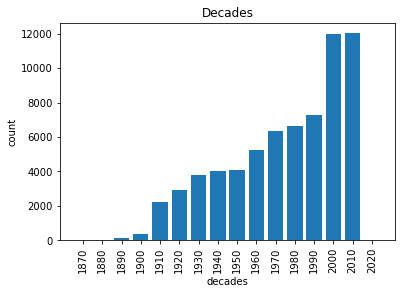

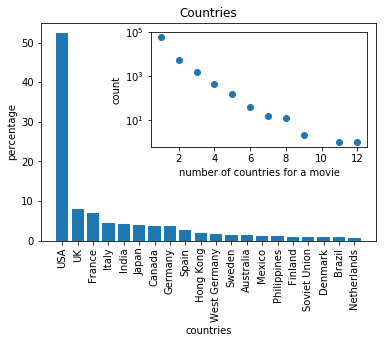

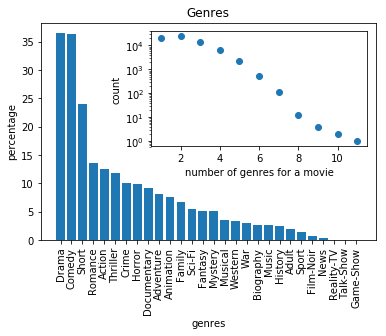

## citations


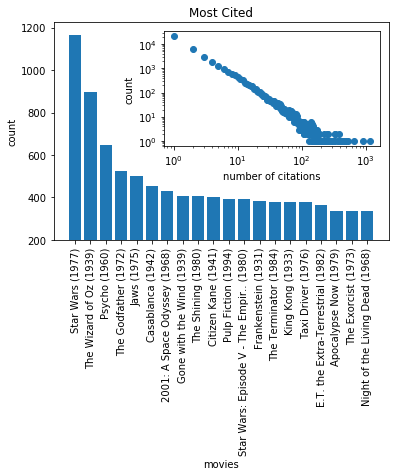

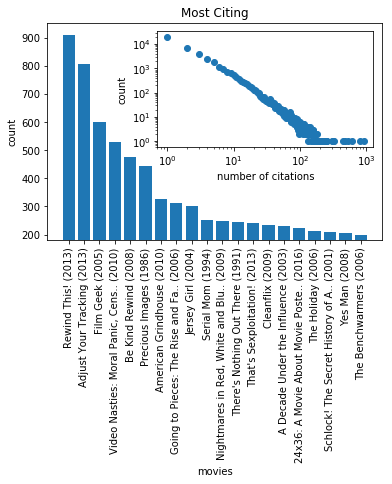

## self citations


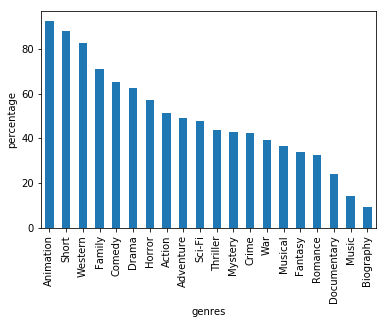

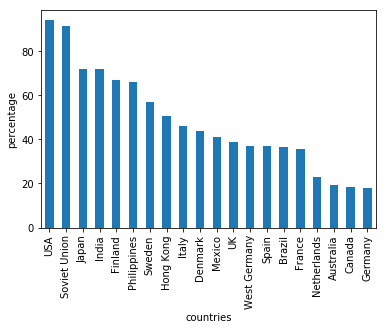

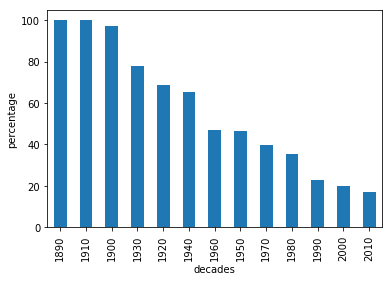

In [6]:
save_all_dataframes(input_dir=DATA_DIR, output_dir=DATA_DIR, images_dir=IMAGES_DIR)

In [7]:
remove_datasets(output_dir=DATA_DIR)


# centrality values

In [8]:
"""
Parallel processing
"""

def get_harmonic_centrality_parallel_func(G, item_list, frm, length, return_dict):
    local_item_list = item_list[frm: min(len(item_list),(frm+length))]
    res = nx.harmonic_centrality(G, nbunch=local_item_list)
    for item in local_item_list:
        return_dict[item] = res[item]
    return

def get_harmonic_centrality_parallel(G, item_list=None, num_threads=0):
    if num_threads == 0:
        num_threads = mp.cpu_count()
    if item_list == None:
        item_list = list(G.nodes())
    # number of items for each thread
    # in python 3, the result of a division is a float!!
    delta = len(item_list)/float(num_threads)
    if (delta).is_integer():
        delta = int(delta)
    else:
        delta = int(delta) + 1
        
    manager = mp.Manager()
    return_dict = manager.dict()

    jobs = []
    for thread in range(num_threads):
        p = mp.Process(target=get_harmonic_centrality_parallel_func, args=(G, item_list, thread*delta, delta, return_dict))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()
    return return_dict.items()

def get_closeness_centrality(G, node):
    return nx.closeness_centrality(G, u=node)

def get_centrality_parallel_func(G, centrality_func, item_list, frm, length, return_dict):
    for item in item_list[frm: min(len(item_list),(frm+length))]:
        return_dict[item] = centrality_func(G, item)
    return

def get_centrality_parallel(G, centrality_func, item_list=None, num_threads=0):
    if num_threads == 0:
        num_threads = mp.cpu_count()
    if item_list == None:
        item_list = list(G.nodes())
    # number of items for each thread
    # in python 3, the result of a division is a float!!
    delta = len(item_list)/float(num_threads)
    if (delta).is_integer():
        delta = int(delta)
    else:
        delta = int(delta) + 1
        
    manager = mp.Manager()
    return_dict = manager.dict()

    jobs = []
    for thread in range(num_threads):
        p = mp.Process(target=get_centrality_parallel_func, args=(G, centrality_func, item_list, thread*delta, delta, return_dict))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()
        
    return_dict = dict(return_dict)
    return return_dict.items()

def normalize_pairs(list_of_pairs):
    max_value = float(max([value for key,value in list_of_pairs]))
    return [(key,value/max_value) for key,value in list_of_pairs]

def calculate_and_save_centralities(input_file, output_file):
    df = pd.read_csv(input_file)
    G = nx.from_pandas_dataframe(df, df.columns[0], df.columns[1], create_using=nx.DiGraph())
    print("Calculating in-degree centrality...")
    df = pd.DataFrame(normalize_pairs(nx.in_degree_centrality(G).items()), columns=[df.columns[0], "in_degree"])
    print("Calculating closeness centrality...")
    df = df.merge(pd.DataFrame(normalize_pairs(get_centrality_parallel(G, get_closeness_centrality)), columns=[df.columns[0], "closeness"]))
    print("Calculating harmonic centrality...")
    df = df.merge(pd.DataFrame(normalize_pairs(get_harmonic_centrality_parallel(G)), columns=[df.columns[0], "harmonic"]))
    print("Calculating pagerank centrality...")
    df = df.merge(pd.DataFrame(normalize_pairs(nx.pagerank(G).items()), columns=[df.columns[0], "pagerank"]))
    #calculate total centrality
    print("Calculating aggregated centrality...")
    df["total_centrality"] = df[df.columns[1:]].sum(axis=1)/float(len(df.columns[1:]))
    df = df.sort_values(by="total_centrality", ascending=False).reset_index(drop=True)
    #save on file
    print("Saving centralities...")
    df.to_csv(output_file, index=False)
    print("...all done!")
    return
    

In [9]:
calculate_and_save_centralities(DATA_DIR+"/links.csv", DATA_DIR+"/centralities.csv")

Calculating in-degree centrality...
Calculating closeness centrality...
Calculating harmonic centrality...
Calculating pagerank centrality...
Calculating aggregated centrality...
Saving centralities...
...all done!


In [10]:
def analyse_network(input_file):
    df = pd.read_csv(input_file)
    G = nx.from_pandas_dataframe(df, df.columns[0], df.columns[1], create_using=nx.DiGraph())
    print G.number_of_nodes(), "nodes"
    print G.number_of_edges(), "edges"
    print nx.number_weakly_connected_components(G), "weakly connected components"
    largest = max(nx.weakly_connected_component_subgraphs(G),key=len)
    print largest.number_of_nodes(), "nodes (","{0:.2f}".format((largest.number_of_nodes()/float(G.number_of_nodes())*100)),"%) on greatest weakly connected component"
    print largest.number_of_edges(), "edges (","{0:.2f}".format((largest.number_of_edges()/float(G.number_of_edges())*100)),"%) on greatest weakly connected component"
    print "##### UNDIRECTED VERSION ####"
    H = G.to_undirected()
    print nx.average_clustering(H), "average clustering"
    return 

analyse_network(DATA_DIR+"/links.csv")

66435 nodes
241586 edges
6725 weakly connected components
47367 nodes ( 71.30 %) on greatest weakly connected component
192014 edges ( 79.48 %) on greatest weakly connected component
##### UNDIRECTED VERSION ####
0.194258110165 average clustering


## Analyse results

In [11]:
def load_data(filename_list):
    res = []
    for filename in filename_list:
        res += [pd.read_csv(filename)]
    return res

def load_data_movies(input_dir):
    return load_data([input_dir+"/titles.csv", input_dir+"/centralities.csv", input_dir+"/years.csv", input_dir+"/genres.csv", input_dir+"/country.csv"])

def get_grouped(df, y_column, sort_by, ascending):
    return df.groupby(y_column).count().reset_index().sort_values(by = sort_by, ascending = ascending)

def get_rank_sorted(titles_csv, centralities_csv, year_csv, genres_csv, countries_csv, by="total_centrality", countries_list=[], genres_list=[], years_list=[]):
    num_col_centralities = len(centralities_csv.columns)
    res = centralities_csv.merge(titles_csv)
    res = res[["title"]+list(res.columns[1:num_col_centralities])+["id"]]
    if countries_list != []:
        res = res.merge(countries_csv[countries_csv["country"].isin(countries_list)])
    if genres_list != []:
        res = res.merge(genres_csv[genres_csv["genre"].isin(genres_list)])
    if years_list != []:
        res = res.merge(year_csv[year_csv["year"].isin(years_list)])
    return res[res.columns].drop_duplicates().sort_values(by=by, ascending=False)

def plot_errorbars(df, xlabel="", ylabel="", filename=""):
    plt.errorbar(range(len(df["mean"])), df["mean"], yerr=df["std"])
    plt.yscale('log')
    plt.xticks(range(len(df["mean"])), df["xlabels"], rotation='vertical')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #save
    if filename != "":
        plt.savefig(filename, bbox_inches='tight', dpi=160)
    plt.show()
    #print df_local
    return

In [12]:
[movie_title, movie_centralities, movie_year, movie_genres, movie_countries] = load_data_movies(DATA_DIR)
movie_centralities["rank"] = 1+movie_centralities.index
print len(movie_centralities), "movies on dataset"

66435 movies on dataset


In [13]:
print "best 20 movies of all times"
get_rank_sorted(movie_title, movie_centralities, movie_year, movie_genres, movie_countries)[:20]

best 20 movies of all times


,title,in_degree,closeness,harmonic,pagerank,total_centrality,rank,id
0,The Wizard of Oz (1939),0.771605,1.000000,1.000000,1.000000,0.942901,1,59825
1,Star Wars (1977),1.000000,0.775877,0.782941,0.714276,0.818273,2,49046
2,Psycho (1960),0.552910,0.907762,0.902281,0.613675,0.744157,3,42282
3,King Kong (1933),0.317460,0.925707,0.887401,0.548401,0.669742,4,27724
4,2001: A Space Odyssey (1968),0.368607,0.875656,0.845186,0.429526,0.629744,5,363
5,Metropolis (1927),0.127866,0.967254,0.936453,0.430660,0.615558,6,34574
6,Citizen Kane (1941),0.350088,0.858071,0.852378,0.398260,0.614699,7,10201
7,The Birth of a Nation (1915),0.072310,0.912547,0.845953,0.585712,0.604131,8,52180
8,Frankenstein (1931),0.329806,0.808538,0.801926,0.413551,0.588455,9,18815
9,Snow White and the Seven Dwarfs (1937),0.179894,0.877427,0.835864,0.400981,0.573541,10,47988


In [14]:
get_rank_sorted(movie_title, movie_centralities, movie_year, movie_genres, movie_countries)[:20][["rank","title","id"]].merge(movie_countries)[["rank","title","country"]]


,rank,title,country
0,1,The Wizard of Oz (1939),USA
1,2,Star Wars (1977),USA
2,3,Psycho (1960),USA
3,4,King Kong (1933),USA
4,5,2001: A Space Odyssey (1968),UK
5,5,2001: A Space Odyssey (1968),USA
6,6,Metropolis (1927),Germany
7,7,Citizen Kane (1941),USA
8,8,The Birth of a Nation (1915),USA
9,9,Frankenstein (1931),USA


best 5 movies by decades
years 1890 - 1899
                                            title  rank
0                       La lune � un m�tre (1898)   716
1                     L'auberge ensorcel�e (1897)  2005
2         L'arriv�e d'un train � La Ciotat (1896)  2824
3                                 The Kiss (1896)  3453
4                         An Easter Parade (1899)  3621
5                             Annie Oakley (1894)  7320
6  Arrestation de J�sus: Trahison de Judas (1899)  7798
7                        L'arroseur arros� (1895)  8234
8                       Entr�e � J�rusalem (1899)  8650
9      La sortie de l'usine Lumi�re � Lyon (1895)  8770
5339.1 3098.52973916
years 1900 - 1909
                                               title  rank
0                     The Great Train Robbery (1903)    62
1                    Dream of a Rarebit Fiend (1906)    81
2                      Le voyage dans la lune (1902)   379
3  What Happened on Twenty-third Street, New York...   768
4      

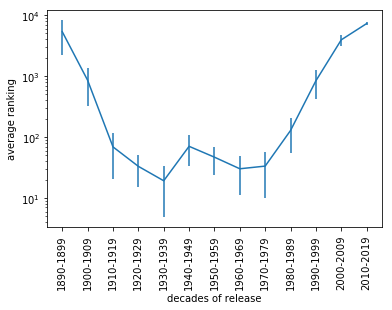

In [15]:
print "best 5 movies by decades"
result = {"mean": [], "std": [], "xlabels": []}
for starting_year in range(1890, 2020, 10):
    print "years", starting_year, "-", (starting_year+9)
    print get_rank_sorted(movie_title, movie_centralities, movie_year, movie_genres, movie_countries, years_list=range(starting_year, starting_year+10))[:10][["title","rank"]]
    temp = get_rank_sorted(movie_title, movie_centralities, movie_year, movie_genres, movie_countries, years_list=range(starting_year, starting_year+10))[:10]["rank"]
    print temp.mean(), temp.std()
    result["xlabels"] += [str(starting_year)+"-"+str(starting_year+9)]
    result["mean"] += [temp.mean()]
    result["std"] += [temp.std()]
result = pd.DataFrame(result, columns = ["mean", "std", "xlabels"])
plot_errorbars(result, xlabel="decades of release", ylabel="average ranking", filename=IMAGES_DIR+"/ranking_decades.png")

best 5 movies by genre
genre:  Drama
                          title  rank
0             Metropolis (1927)     6
1           Citizen Kane (1941)     7
2  The Birth of a Nation (1915)     8
3           Frankenstein (1931)     9
4             Casablanca (1942)    12
5          The Godfather (1972)    13
6                   Jaws (1975)    15
7                Cabiria (1914)    16
8          The Searchers (1956)    17
9   Bronenosets Potemkin (1925)    18
12.1 4.38304815295
genre:  Comedy
                                               title  rank
0  Dr. Strangelove or: How I Learned to Stop Worr...    19
1                         Singin' in the Rain (1952)    26
2                             La r�gle du jeu (1939)    34
3                               La dolce vita (1960)    35
4                            The Wizard of Oz (1925)    48
5                             Sh! The Octopus (1937)    50
6                   The Poor Little Rich Girl (1917)    51
7                                 The T

23.0 18.0554700853
genre:  Mystery
                                 title  rank
0                        Psycho (1960)     3
1                  Citizen Kane (1941)     7
2                       Vertigo (1958)    22
3  Das Cabinet des Dr. Caligari (1920)    23
4            North by Northwest (1959)    43
5               Sh! The Octopus (1937)    50
6          The City of the Dead (1960)    61
7                   Rear Window (1954)    65
8  L'ann�e derni�re � Marienbad (1961)    73
9                     The Birds (1963)    76
42.3 27.0351622891
genre:  Musical
                                    title  rank
0                 The Wizard of Oz (1939)     1
1  Snow White and the Seven Dwarfs (1937)    10
2              Singin' in the Rain (1952)    26
3                        Oklahoma! (1955)    79
4                Three Little Pigs (1933)    82
5                            Dumbo (1941)   103
6                  The Merry Widow (1934)   110
7                  The Jazz Singer (1927)   122
8  

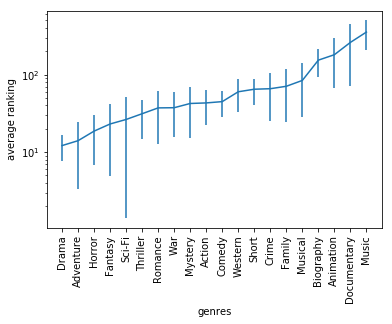

In [16]:
print "best 5 movies by genre"
result = {"mean": [], "std": [], "xlabels": []}
for genre in get_grouped(movie_genres, "genre", "id", False)[:20]["genre"]:
    print "genre: ", genre
    print get_rank_sorted(movie_title, movie_centralities, movie_year, movie_genres, movie_countries, genres_list=[genre])[:10][["title","rank"]]
    temp = get_rank_sorted(movie_title, movie_centralities, movie_year, movie_genres, movie_countries, genres_list=[genre])[:10]["rank"]
    print temp.mean(), temp.std()
    result["xlabels"] += [genre]
    result["mean"] += [temp.mean()]
    result["std"] += [temp.std()]
result = pd.DataFrame(result, columns = ["mean", "std", "xlabels"])
plot_errorbars(result.sort_values(by = "mean", ascending = True), xlabel="genres", ylabel="average ranking", filename=IMAGES_DIR+"/ranking_genres.png")


best 5 movies by country
country:  USA
                                    title  rank
0                 The Wizard of Oz (1939)     1
1                        Star Wars (1977)     2
2                           Psycho (1960)     3
3                        King Kong (1933)     4
4            2001: A Space Odyssey (1968)     5
5                     Citizen Kane (1941)     7
6            The Birth of a Nation (1915)     8
7                     Frankenstein (1931)     9
8  Snow White and the Seven Dwarfs (1937)    10
9                          Dracula (1931)    11
6.0 3.4960294939
country:  UK
                                               title  rank
0                       2001: A Space Odyssey (1968)     5
1  Dr. Strangelove or: How I Learned to Stop Worr...    19
2                          A Clockwork Orange (1971)    21
3                                      Dr. No (1962)    24
4                                 The Shining (1980)    36
5                              The Terminator (19

                                         title  rank
0                  Bronenosets Potemkin (1925)    18
1                               Stachka (1925)    75
2                     Aleksandr Nevskiy (1938)   139
3                           Dersu Uzala (1975)   236
4                           Dersu Uzala (1961)   557
5                          Ivan Groznyy (1945)   980
6                              Solyaris (1972)  1520
7                               Stalker (1979)  1628
8                                 Idiot (1958)  1631
9  Razgrom nemetskikh voysk pod Moskvoy (1942)  1978
876.2 760.685334273
country:  Denmark
                               title  rank
0                     Dv�rgen (1973)   859
1                 Vredens dag (1943)   973
2             Jeg - en kvinde (1965)  1186
3           Jeg, en kvinda II (1968)  1188
4       Forbrydelsens element (1984)  2158
5               Uden en tr�vl (1968)  3353
6          Dansen med Regitze (1989)  3898
7                  Reptilicus (1961

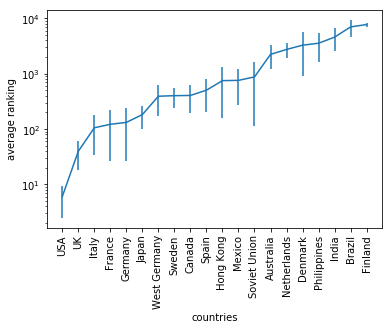

In [17]:
print "best 5 movies by country"
result = {"mean": [], "std": [], "xlabels": []}
for country in get_grouped(movie_countries, "country", "id", False)[:20]["country"]:
    print "country: ", country
    print get_rank_sorted(movie_title, movie_centralities, movie_year, movie_genres, movie_countries, countries_list=[country])[:10][["title","rank"]]
    temp = get_rank_sorted(movie_title, movie_centralities, movie_year, movie_genres, movie_countries, countries_list=[country])[:10]["rank"]
    print temp.mean(), temp.std()
    result["xlabels"] += [country]
    result["mean"] += [temp.mean()]
    result["std"] += [temp.std()]
result = pd.DataFrame(result, columns = ["mean", "std", "xlabels"])
plot_errorbars(result.sort_values(by = "mean", ascending = True), xlabel="countries", ylabel="average ranking", filename=IMAGES_DIR+"/ranking_countries.png")
